주간test개수:  77
일별test개수:  722
Epoch 1/2
512/512 [==============================] - 3s 5ms/step - loss: 0.0495
Epoch 2/2
512/512 [==============================] - 2s 3ms/step - loss: 0.0370
Train on 3419 samples, validate on 855 samples
Epoch 1/2
3419/3419 [==============================] - 5s 1ms/step - loss: 0.0113 - val_loss: 0.0051
Epoch 2/2
3419/3419 [==============================] - 4s 1ms/step - loss: 0.0097 - val_loss: 0.0057


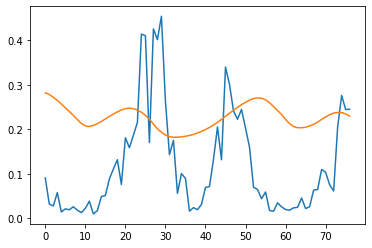

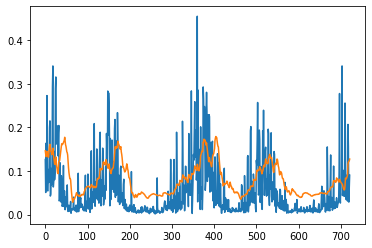

In [2]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

weekfrom = 2
weekto = 33
week = weekto - weekfrom

dayfrom = 14
dayto = 42
day = dayto - dayfrom

df = pd.read_csv('seoulbigparkdata.csv', engine='python')
# print(df.head())

df["날짜"] = df["년도"].map(str) + '-' +df["월"].map(str) + '-' + df["일"].map(str)#날짜 column생성
# print(df.head())

df = df.set_index('날짜') 
# print(df.head())
# df.plot()

split_date_last = '2016-12-17'
split_date_start = '2017-3-30'

train = df.loc[:split_date_last, ['일계']]
test = df.loc[split_date_start:, ['일계']]
# print(train.head())

train['일계'] = train['일계'].str.replace(',', '')
test['일계'] = test['일계'].str.replace(',', '')

train['일계'] = train['일계'].astype('float')
test['일계'] = test['일계'].astype('float')

#*************************************주 단위 15년동안의 입장객수 경향************************************************
#주단위 데이터로 변환. train2, test2.
train2 = train.iloc[0:0]
traintmp2 = train
for i in range(int(len(train)/7)):
    traintmp = train['일계'][i*7:i*7+7]
    traintmp2['일계'][i*7+6] = traintmp.mean(axis = 0)
    train2 = pd.concat([train2, traintmp2[i*7+6:i*7+7]], axis=0)
    
test2 = test.iloc[0:0]
testtmp2 = test
for i in range(int(len(test)/7)):
    testtmp = test['일계'][i*7:i*7+7]
    testtmp2['일계'][i*7+6] = testtmp.mean(axis = 0)
    test2 = pd.concat([test2, testtmp2[i*7+6:i*7+7]], axis=0)
# print(test2.head)

# plt.plot(train2)
# plt.show()

#***********************************************************************************************************************
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler()

train_sc2 = sc.fit_transform(train2)
test_sc2 = sc.transform(test2)

train_sc = sc.fit_transform(train)
test_sc = sc.transform(test)

# print(train_sc)

train_sc_df2 = pd.DataFrame(train_sc2, columns=['Scaled'], index=train2.index)
test_sc_df2 = pd.DataFrame(test_sc2, columns=['Scaled'], index=test2.index)
# print(train_sc_df.head())

train_sc_df = pd.DataFrame(train_sc, columns=['Scaled'], index=train.index)
test_sc_df = pd.DataFrame(test_sc, columns=['Scaled'], index=test.index)
# print(train_sc_df.head())


for s in range(weekfrom, weekto):
    train_sc_df2['shift_{}'.format(s)] = train_sc_df2['Scaled'].shift(s)
    test_sc_df2['shift_{}'.format(s)] = test_sc_df2['Scaled'].shift(s)
    
for s in range(dayfrom, dayto):
    train_sc_df['shift_{}'.format(s)] = train_sc_df['Scaled'].shift(s)
    test_sc_df['shift_{}'.format(s)] = test_sc_df['Scaled'].shift(s)
    

X_train2 = train_sc_df2.dropna().drop('Scaled', axis=1)
y_train2 = train_sc_df2.dropna()[['Scaled']]
# print(X_train.head())
# print(y_train.head())

X_train = train_sc_df.dropna().drop('Scaled', axis=1)
y_train = train_sc_df.dropna()[['Scaled']]
# print(X_train.head())
# print(y_train.head())

X_test2 = test_sc_df2.dropna().drop('Scaled', axis=1)
y_test2 = test_sc_df2.dropna()[['Scaled']]

X_test = test_sc_df.dropna().drop('Scaled', axis=1)
y_test = test_sc_df.dropna()[['Scaled']]

X_train2 = X_train2.values
X_test2= X_test2.values

y_train2 = y_train2.values
y_test2 = y_test2.values

X_train_t2 = X_train2.reshape(X_train2.shape[0], week, 1)
X_test_t2 = X_test2.reshape(X_test2.shape[0], week, 1)

X_train = X_train.values
X_test= X_test.values

y_train = y_train.values
y_test = y_test.values

X_train_t = X_train.reshape(X_train.shape[0], day, 1)
X_test_t = X_test.reshape(X_test.shape[0], day, 1)

print('주간test개수: ', len(y_test2))
print('일별test개수: ', len(y_test))

from keras.layers import LSTM 
from keras.models import Sequential 
from keras.layers import Dense 
import keras.backend as K 
from keras.callbacks import EarlyStopping 
from keras import optimizers
K.clear_session()
model2 = Sequential() # Sequeatial Model 
model2.add(LSTM(60, input_shape=(week, 1), return_sequences = True)) # (timestep, feature)
model2.add(LSTM(60))
model2.add(Dense(1)) # output = 1 
adam2 = optimizers.Adam(lr=0.0004)
model2.compile(loss='mean_squared_error', optimizer=adam2) 
# print(model.summary())

early_stop2 = EarlyStopping(monitor='loss', patience=30, verbose=1)

model2.fit(X_train_t2, y_train2, epochs=200,
          batch_size=10, verbose=1, callbacks=[early_stop2])
#***************************위는 주간, 아래는 일간**********************************************************
model = Sequential() # Sequeatial Model 
model.add(LSTM(56, input_shape=(day, 1), return_sequences = True)) # (timestep, feature)
model.add(LSTM(56))
model.add(Dense(1)) # output = 1 
adam = optimizers.Adam(lr=0.001)
model.compile(loss='mean_squared_error', optimizer=adam) 
# print(model.summary())

early_stop = EarlyStopping(monitor='val_loss', patience=30, verbose=1)

model.fit(X_train_t, y_train, epochs=200,
          batch_size=30, verbose=1, validation_split = 0.2, callbacks=[early_stop])


y_pred2 = model2.predict(X_test_t2)
plt.plot(y_test2)
plt.plot(y_pred2)
plt.show()

y_pred = model.predict(X_test_t)
plt.plot(y_test)
plt.plot(y_pred)
plt.show()

